In [1]:
import os
import gc

# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
gc.collect()

0

In [2]:
import numpy as np
from pathlib import Path
import tempfile

import torch
from torch import nn
import torch.nn.functional as F

from ray import tune
from ray.train import Checkpoint, get_checkpoint
import ray.cloudpickle as pickle

from data_prep import clean_data, dataset
from data_prep.utils import shuffle_by_timestep, shuffle_non_padded, masked_mae, compute_iou
from models import transformer

import ipywidgets as widgets
from matplotlib import pyplot as plt

from scipy.spatial.distance import squareform

In [3]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


# Data loading

In [4]:
df = clean_data.load_data()
df = clean_data.clean_data(df)

c:\Users\pauls\Projects\NSCI-retention-modeling\outcome_modeling\data_prep\clean_data.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['COURSE'] = df['SUBJECT'] + ' ' + df['COURSE_NUMBER']


Mappings used to identify courses from ids

In [5]:
course_id_map, id_course_map = clean_data.course_id_maps(df)

In [6]:
major_id_map, id_major_map = clean_data.major_id_maps(df)

In [7]:
PAD_IDX = course_id_map["<PAD>"]
SOS_IDX = course_id_map["<SOS>"]
EOS_IDX = course_id_map["<EOS>"]

Load tensors

In [8]:
student_seqs, student_tensors, semester_tensors, major_tensors, grade_tensors = dataset.course_semester_tensors(df)

In [9]:
n_students = len(student_seqs)
n_courses = len(course_id_map)
n_semesters = df['SEMESTER_RANK'].nunique()
n_majors = len(major_id_map) 

print(f'{n_students} students, {n_courses} courses, {n_majors} majors, {n_semesters} "semesters"')

5326 students, 360 courses, 48 majors, 18 "semesters"


In [10]:
student_tensor_sizes = [x.size()[0] for x in student_tensors]
print(f'Min courses: {min(student_tensor_sizes)}, Max courses: {max(student_tensor_sizes)}')

Min courses: 7, Max courses: 58


Load dataloaders

In [11]:
train_dataloader, test_dataloader = dataset.course_seq_dataloader(student_tensors, semester_tensors, major_tensors, grade_tensors, n_courses, SOS_IDX, EOS_IDX, PAD_IDX, batch_size=32)

## Data sanity check

Grab a single batch for testing

In [12]:
for X, X_pos, y, y_pos, majors, input_grades, target_grades in train_dataloader:
    assert X.size() == X_pos.size()
    assert y.size() == y_pos.size()
    assert input_grades.size() == X.size()
    assert target_grades.size() == y.size()

    # Place on device
    X = X.to(device)
    y = y.to(device)
    X_pos = X_pos.to(device)
    y_pos = y_pos.to(device)
    majors = majors.to(device)
    input_grades = input_grades.to(device)
    target_grades = target_grades.to(device)
    
    break

In [13]:
src_courses=X
tgt_courses=y 
src_gpas=input_grades
tgt_gpas=target_grades
src_courses_positions=X_pos
tgt_courses_positions=y_pos
major=majors
memory_key_padding_mask=None

In [14]:
print(f'major: {major.size()}')

print(f'src_courses: {src_courses.size()}')
print(f'src_gpas: {src_gpas.size()}')
print(f'src_courses_positions: {src_courses_positions.size()}')

print(f'tgt_courses: {tgt_courses.size()}')
print(f'tgt_gpas: {tgt_gpas.size()}')
print(f'tgt_courses_positions: {tgt_courses_positions.size()}')

major: torch.Size([32])
src_courses: torch.Size([32, 56])
src_gpas: torch.Size([32, 56])
src_courses_positions: torch.Size([32, 56])
tgt_courses: torch.Size([32, 12])
tgt_gpas: torch.Size([32, 12])
tgt_courses_positions: torch.Size([32, 12])


In [15]:
print(f'major: {major[0]}\n')

print(f'src_courses:\n {src_courses[0]}\n')
print(f'src_gpas:\n {src_gpas[0]}\n')
print(f'src_courses_positions:\n {src_courses_positions[0]}\n')

print(f'tgt_courses:\n {tgt_courses[0]}\n')
print(f'tgt_gpas:\n {tgt_gpas[0]}\n')
print(f'tgt_courses_positions:\n {tgt_courses_positions[0]}\n')

major: 6

src_courses:
 tensor([358,  13,  17,  32,  44,  50,  72,  96, 359,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       device='cuda:0')

src_gpas:
 tensor([0.0000, 0.9302, 1.0000, 0.9302, 0.9302, 0.9302, 0.6977, 0.4651, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000], device='cuda:0')

src_courses_positions:
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,


In [16]:
print(f'src_courses:\n {[id_course_map[x.item()] for x in src_courses[0]]}\n')
print(f'tgt_courses:\n {[id_course_map[x.item()] for x in tgt_courses[0]]}\n')
print(f'major: {id_major_map[major[0].item()]}\n')
print(f'src_courses_positions:\n {src_courses_positions[0]}\n')
print(f'tgt_courses_positions:\n {tgt_courses_positions[0]}\n')

src_courses:
 ['<SOS>', 'BIOL 1107', '<OTHER>', 'WRIT 1301', 'SPAN 1312', 'FYSM 1100', 'BIOL 1307', 'MATH 2312', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']

tgt_courses:
 ['<SOS>', 'COMM 1317', 'MATH 2413', 'BIOL 1308', 'BIOL 1108', 'GLST 1322', 'RELS 2342', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']

major: Biology

src_courses_positions:
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

tgt_courses_positions:
 tensor([2, 2, 2, 2, 2, 2, 2, 2,

Generate padding masks

In [ ]:
src_key_padding_mask = dataset.generate_src_padding_masks(src_courses, major, PAD_IDX).to(device)
tgt_key_padding_mask = dataset.generate_tgt_padding_masks(tgt_courses, PAD_IDX).to(device)

In [ ]:
assert 1 + src_courses.size(1) + src_gpas.size(1) == src_key_padding_mask.size(1), "Padding mask size doesn't match src size"

Visually inspect padding masks. `False` is _not_ padding, `True` _is_ padding.

Source masks

In [ ]:
src_key_padding_mask[0, 0], major[0]

(tensor(False, device='cuda:0'), tensor(2, device='cuda:0'))

In [ ]:
src_key_padding_mask[0, 1:src_courses.size(1)], src_courses[0]

(tensor([False, False,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        device='cuda:0'),
 tensor([358, 359,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0], device='cuda:0'))

In [ ]:
src_key_padding_mask[0, 1+src_courses.size(1):2*src_courses.size(1)], src_gpas[0]

(tensor([False, False,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        device='cuda:0'),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0'))

Target masks

In [ ]:
tgt_key_padding_mask[0, :tgt_courses.size(1)], tgt_courses[0]

(tensor([False, False, False, False, False, False, False,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        device='cuda:0'),
 tensor([358,  28,  29,  34,  58, 201, 359,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0], device='cuda:0'))

In [ ]:
tgt_key_padding_mask[0, 1+tgt_courses.size(1):], tgt_gpas[0]

(tensor([False, False, False, False, False, False,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True],
        device='cuda:0'),
 tensor([0.0000, 0.6977, 0.9302, 0.4651, 0.0000, 0.6279, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000], device='cuda:0'))

Generate source mask

In [ ]:
# Add one for the major
src_seq_len = 1 + src_courses.size(1) + src_gpas.size(1)
tgt_courses_seq_len = tgt_courses.size(1)

src_mask = dataset.generate_src_mask(src_seq_len).to(device)
tgt_mask = dataset.generate_tgt_mask(tgt_courses_seq_len).to(device)

In [ ]:
src_seq_len, tgt_courses_seq_len

(123, 20)

In [ ]:
src_mask.size(), tgt_mask.size()

(torch.Size([123, 123]), torch.Size([40, 40]))

In [ ]:
assert ~src_mask.all(), "All elements of src_mask should be False"

In [ ]:
tgt_mask

tensor([[0., -inf, -inf,  ..., -inf, -inf, -inf],
        [0., 0., -inf,  ..., -inf, -inf, -inf],
        [0., 0., 0.,  ..., -inf, -inf, -inf],
        ...,
        [0., 0., 0.,  ..., 0., -inf, -inf],
        [0., 0., 0.,  ..., 0., 0., -inf],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

# Model fitting

In [12]:
config = dict()
config['d_model'] = 128
config['nhead'] = 8
config['num_encoder_layers'] = 4
config['num_decoder_layers'] = 4
config['dim_feedforward'] = 512
config['major_embedding_dim'] = 16
config['course_embedding_dim'] = 100
config['gpa_embedding_dim'] = 16
config['dropout'] = 0.1
config['lr'] = 1e-4
config['weight_decay'] = 0.1

model = transformer.TransformerModelWithGrades(n_courses=n_courses,
                                               n_majors=n_majors,
                                               max_len=100,
                                               config=config,
                                               PAD_IDX=PAD_IDX).to(device)

model = nn.DataParallel(model, device_ids=[0, 1])

## Sample forward pass

In [15]:
# Shift target to the right
# Input targets to the decoder ignore the last element
# Prediction targets ignore the first element
tgt_courses_input = tgt_courses.detach().clone()
tgt_grades_input = target_grades.detach().clone()
tgt_pos_input = tgt_courses_positions.detach().clone()

# Find index of EOS_IDX in tgt_courses
eos_tgt_loc = (tgt_courses_input == EOS_IDX).nonzero()
tgt_courses_input[eos_tgt_loc[:, 0], eos_tgt_loc[:, 1]] = PAD_IDX
tgt_grades_input[eos_tgt_loc[:, 0], eos_tgt_loc[:, 1]] = 0.
tgt_pos_input[eos_tgt_loc[:, 0], eos_tgt_loc[:, 1]] = 0

# Now trim off the last element
tgt_courses_input = tgt_courses_input[:, :-1]
tgt_grades_input = tgt_grades_input[:, :-1]
tgt_pos_input = tgt_pos_input[:, :-1]

tgt_out = tgt_courses[:, 1:]
tgt_grades_out = target_grades[:, 1:]
tgt_pos_out = tgt_courses_positions[:, 1:]

# Source and target masks
# Add one for the major
# src_seq_len = 1 + src_courses.size(1) + src_gpas.size(1)
# tgt_input_courses_seq_len = tgt_grades_input.size(1)

# src_mask = dataset.generate_src_mask(src_seq_len).to(device)
# tgt_input_mask = dataset.generate_tgt_mask(tgt_input_courses_seq_len).to(device)

# # Padding masks
# src_key_padding_mask = dataset.generate_src_padding_masks(src_courses, majors, PAD_IDX).to(device)
# tgt_key_padding_input_mask = dataset.generate_tgt_padding_masks(tgt_courses_input, PAD_IDX).to(device)

# Place on device
majors = majors.to(device)
src_courses = src_courses.to(device)
tgt_courses_input = tgt_courses_input.to(device)
src_gpas = src_gpas.to(device)
tgt_grades_input = tgt_grades_input.to(device)
src_courses_positions = src_courses_positions.to(device)
tgt_pos_input = tgt_pos_input.to(device)
# src_key_padding_mask = src_key_padding_mask.to(device)

# Forward pass
output_courses_lsm, output_gpas, output_courses = model(major=majors,
                                                        src_courses=src_courses, 
                                                        tgt_courses=tgt_courses_input, 
                                                        src_gpas=src_gpas, 
                                                        tgt_gpas=tgt_grades_input, 
                                                        src_courses_positions=src_courses_positions, 
                                                        tgt_courses_positions=tgt_pos_input,
                                                        # src_mask=src_mask,
                                                        # tgt_mask=tgt_input_mask,
                                                        # src_key_padding_mask=src_key_padding_mask,
                                                        # tgt_key_padding_mask=tgt_key_padding_input_mask,
                                                        # memory_key_padding_mask=src_key_padding_mask)
)

c:\Users\pauls\Projects\NSCI-retention-modeling\venv\Lib\site-packages\torch\nn\functional.py:5109: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(
c:\Users\pauls\Projects\NSCI-retention-modeling\venv\Lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
c:\Users\pauls\Projects\NSCI-retention-modeling\venv\Lib\site-packages\torch\nn\functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


In [16]:
print(f'output_courses: {output_courses.size()}')
print(f'output_gpas: {output_gpas.size()}')
print(f'output_courses_lsm: {output_courses_lsm.size()}')

output_courses: torch.Size([32, 360, 11])
output_gpas: torch.Size([32, 11, 1])
output_courses_lsm: torch.Size([32, 360, 11])


In [17]:
assert output_courses.isnan().sum().item() == 0, "nan values in output_courses"
assert output_gpas.isnan().sum().item() == 0, "nan values in output_gpas"
assert output_courses_lsm.isnan().sum().item() == 0, "nan values in output_courses_lsm"

In [18]:
majors[0], src_courses[0], src_gpas[0], src_courses_positions[0]

(tensor(2, device='cuda:0'),
 tensor([358,  33,  34,  35, 198, 210,  28,  29,  57,  58, 195,  27,  32,  56,
          60,  61,  32,  59,  65,  71, 126, 359,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        device='cuda:0'),
 tensor([0.0000, 0.9302, 1.0000, 0.6977, 1.0000, 1.0000, 0.8605, 0.9302, 0.9302,
         0.6977, 0.9302, 0.9302, 0.0000, 0.4651, 0.6977, 0.6977, 0.7674, 0.6977,
         0.6977, 0.7674, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000], device='cuda:0'),
 tensor([1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 0, 0,
         0, 0, 0,

In [25]:
tgt_courses[0], target_grades[0], tgt_courses_positions[0]

(tensor([358,   1,   2,  23, 102, 125, 359,   0,   0,   0,   0,   0],
        device='cuda:0'),
 tensor([0.0000, 0.9302, 0.9302, 0.9302, 0.9302, 0.9302, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000], device='cuda:0'),
 tensor([0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0], device='cuda:0'))

In [28]:
output_courses.max(dim=1).indices[0].sort().values

tensor([139, 139, 223, 223, 250, 250, 250, 316, 317, 335, 344],
       device='cuda:0')

In [32]:
[id_course_map[x.item()] for x in tgt_courses[0].sort().values]

['<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 'PSYC 2310',
 'PSYC 2317',
 'RELS 1304',
 'KINE 1118',
 'BIOL 1322',
 '<SOS>',
 '<EOS>']

In [31]:
[id_course_map[x.item()] for x in output_courses.max(dim=1).indices[0].sort().values]

['MUSI 1271',
 'MUSI 1271',
 'ASTR 1111',
 'ASTR 1111',
 'PSYC 2306',
 'PSYC 2306',
 'PSYC 2306',
 'ARTS 2304',
 'THAR 2347',
 'HIST 1302',
 'HONS 2329']

Testing loss function

In [19]:
course_loss_fn = nn.KLDivLoss(reduction='batchmean')
gpa_loss_fn = nn.MSELoss(reduction='none')

course_loss_weight = 1

# Course prediction loss function
# Summing along dimension 1 creates a vector which has a 1 for each
# course they actually took. Padding will be counted multiple times to
# encourage the model to not over-predict courses.
y_oh = F.one_hot(tgt_out, num_classes=n_courses).sum(dim=1)
# y_oh = torch.clamp(y_oh, 0, 1)
y_norm = y_oh / y_oh.sum(dim=1, keepdim=True)

# Mask the padding values when computing loss
course_loss = course_loss_fn(output_courses_lsm, y_norm)
print(f'course_loss: {course_loss.item()}')

# GPA loss function
# Mask the padding values when computing loss
gpa_loss = gpa_loss_fn(output_gpas.squeeze(2), tgt_grades_out)
mask = torch.ones_like(tgt_grades_out)
mask[tgt_pos_out == 0] = 0
masked_loss = gpa_loss * mask
gpa_reduced_loss = masked_loss.sum() / mask.sum()
print(f'GPA loss: {gpa_reduced_loss.item()}')

loss = course_loss_weight*course_loss + gpa_reduced_loss
print(f'loss: {loss.item()}')

RuntimeError: The size of tensor a (360) must match the size of tensor b (11) at non-singleton dimension 2

## Train and test functions

Parameters for training. Several of these would benefit from tuning.

In [13]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])

# Learning rate scheduler
def lr_lambda(current_step):
    warmup_steps = 500
    d_model = model.d_model  # Typically the size of the embedding
    
    # Ensure current_step is at least 1 to avoid division by zero
    current_step = max(current_step, 1)
    
    arg1 = current_step ** -0.5
    arg2 = current_step * (warmup_steps ** -1.5)
    return d_model ** -0.5 * min(arg1, arg2)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=5)


In [14]:
course_loss_fn = nn.NLLLoss(reduction='mean')
gpa_loss_fn = nn.MSELoss(reduction='none')

course_loss_weight = 1

Train and test functions

In [15]:
def train(device, dataloader, model, course_loss_fn, gpa_loss_fn, optimizer):
    size = len(dataloader.dataset)

    model.to(device)

    # Put model in training mode
    model.train()

    # Iterate over batches
    for batch, (src_courses, src_courses_positions, tgt_courses, tgt_courses_positions, majors, src_gpas, target_grades) in enumerate(dataloader):
        # Shift target to the right
        # Input targets to the decoder ignore the last element
        # Prediction targets ignore the first element
        tgt_courses_input = tgt_courses.detach().clone().to(device)
        tgt_grades_input = target_grades.detach().clone().to(device)
        tgt_pos_input = tgt_courses_positions.detach().clone().to(device)

        # Find index of EOS_IDX in tgt_courses
        eos_tgt_loc = (tgt_courses_input == EOS_IDX).nonzero()
        tgt_courses_input[eos_tgt_loc[:, 0], eos_tgt_loc[:, 1]] = PAD_IDX
        tgt_grades_input[eos_tgt_loc[:, 0], eos_tgt_loc[:, 1]] = 0.
        tgt_pos_input[eos_tgt_loc[:, 0], eos_tgt_loc[:, 1]] = 0

        # Now trim off the last element
        tgt_courses_input = tgt_courses_input[:, :-1].to(device)
        tgt_grades_input = tgt_grades_input[:, :-1].to(device)
        tgt_pos_input = tgt_pos_input[:, :-1].to(device)

        tgt_out = tgt_courses[:, 1:].to(device) 
        tgt_grades_out = target_grades[:, 1:].to(device)
        tgt_pos_out = tgt_courses_positions[:, 1:].to(device)

        # Place on device
        src_courses = src_courses.to(device)
        src_courses_positions = src_courses_positions.to(device)
        majors = majors.to(device)
        src_gpas = src_gpas.to(device)

        # Forward pass
        output_courses_lsm, output_gpas, output_courses = model(major=majors,
                                                                src_courses=src_courses, 
                                                                tgt_courses=tgt_courses_input, 
                                                                src_gpas=src_gpas, 
                                                                tgt_gpas=tgt_grades_input, 
                                                                src_courses_positions=src_courses_positions, 
                                                                tgt_courses_positions=tgt_pos_input)


        # Mask the padding values when computing loss
        course_loss = course_loss_fn(output_courses_lsm, tgt_out)

        # GPA loss function
        # Mask the padding values when computing loss
        gpa_loss = gpa_loss_fn(output_gpas.squeeze(2), tgt_grades_out)
        mask = torch.ones_like(tgt_grades_out)
        mask[tgt_pos_out == 0] = 0
        masked_loss = gpa_loss * mask
        gpa_reduced_loss = masked_loss.sum() / mask.sum()

        loss = course_loss_weight*course_loss + gpa_reduced_loss

        # Backprop
        nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        current_lr = optimizer.param_groups[0]['lr'] 

        if batch % 200 == 0:
            loss_val, current = loss.item(), (batch + 1) * len(src_courses)
            course_weight_pct = course_loss_weight*course_loss / loss
            gpa_weight_pct = gpa_reduced_loss / loss
            print(f'loss: {loss_val:>7f} [{current/size:.1%}] ({course_weight_pct:.1%} course, {gpa_weight_pct:.1%} gpa)')
    print(f'LR = {current_lr}')
    scheduler.step()
    return loss.item()

In [18]:
def test(device, dataloader, model):
    # Put the model in evaluation mode
    model.eval()

    # Make predictions but don't calculate gradients on forward pass
    with torch.no_grad():
        # Iterate over batches
        for batch, (src_courses, src_courses_positions, tgt_courses, tgt_courses_positions, majors, src_gpas, target_grades) in enumerate(dataloader):
            # Shift target to the right
            # Input targets to the decoder ignore the last element
            # Prediction targets ignore the first element
            tgt_courses_input = tgt_courses.detach().clone().to(device)
            tgt_grades_input = target_grades.detach().clone().to(device)
            tgt_pos_input = tgt_courses_positions.detach().clone().to(device)

            # Find index of EOS_IDX in tgt_courses
            eos_tgt_loc = (tgt_courses_input == EOS_IDX).nonzero()
            tgt_courses_input[eos_tgt_loc[:, 0], eos_tgt_loc[:, 1]] = PAD_IDX
            tgt_grades_input[eos_tgt_loc[:, 0], eos_tgt_loc[:, 1]] = 0.
            tgt_pos_input[eos_tgt_loc[:, 0], eos_tgt_loc[:, 1]] = 0

            # Now trim off the last element
            tgt_courses_input = tgt_courses_input[:, :-1].to(device)
            tgt_grades_input = tgt_grades_input[:, :-1].to(device)
            tgt_pos_input = tgt_pos_input[:, :-1].to(device)

            tgt_out = tgt_courses[:, 1:].to(device) 
            tgt_grades_out = target_grades[:, 1:].to(device)
            tgt_pos_out = tgt_courses_positions[:, 1:].to(device)

            # Place on device
            src_courses = src_courses.to(device)
            src_courses_positions = src_courses_positions.to(device)
            majors = majors.to(device)
            src_gpas = src_gpas.to(device)

            # Forward pass
            output_courses_lsm, output_gpas, output_courses = model(major=majors,
                                                                    src_courses=src_courses, 
                                                                    tgt_courses=tgt_courses_input, 
                                                                    src_gpas=src_gpas, 
                                                                    tgt_gpas=tgt_grades_input, 
                                                                    src_courses_positions=src_courses_positions, 
                                                                    tgt_courses_positions=tgt_pos_input)

            # # Course prediction loss
            course_loss = course_loss_fn(output_courses_lsm, tgt_out)

            # GPA loss function
            # Mask the padding values when computing loss
            gpa_loss = gpa_loss_fn(output_gpas.squeeze(2), tgt_grades_out)
            mask = torch.ones_like(tgt_grades_out)
            mask[tgt_pos_out == 0] = 0
            masked_loss = gpa_loss * mask
            gpa_reduced_loss = masked_loss.sum() / mask.sum()

            loss = course_loss_weight*course_loss + gpa_reduced_loss
        
            # Get class predictions
            pred_courses = output_courses.argmax(dim=1)


            # Compute IOU for courses for the whole batch
            # mean_iou = compute_iou(pred_courses, tgt_out, PAD_IDX, EOS_IDX, n_courses-2, True)

            # Get predicted grades
            # gpas_mask = tgt_pos_out != 0

            # Compute MAE
            # mae = masked_mae(output_gpas.squeeze(2), tgt_grades_out, gpas_mask)      
    
    # print(f'Loss: {loss:.4f}, Mean IOU: {mean_iou:.1%}, MAE: {mae:.4f} \n')
    print(f'Sample')
    print(f'\tPredicted: {pred_courses[0].squeeze()}')
    print(f'\tActual: {tgt_out[0].squeeze()}')
    print(f'Test loss: {loss.item():>7f}')

    return loss.item()

In [19]:
epochs = 20
train_losses = []
test_losses = []

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}\n-------------------------------')
    train_loss = train(device, train_dataloader, model, course_loss_fn, gpa_loss_fn, optimizer)
    test_loss = test(device, test_dataloader, model)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

Epoch 1
-------------------------------


c:\Users\pauls\Projects\NSCI-retention-modeling\venv\Lib\site-packages\torch\nn\functional.py:5109: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(
c:\Users\pauls\Projects\NSCI-retention-modeling\venv\Lib\site-packages\torch\nn\functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Sample
	Predicted: tensor([ 17,  32,  96, 359, 359,   0,   0,   0,   0,   0,   0],
       device='cuda:0')
	Actual: tensor([ 61, 120, 167, 231, 359,   0,   0,   0,   0,   0,   0],
       device='cuda:0')
Test loss: 2.143216
Epoch 2
-------------------------------
Sample
	Predicted: tensor([ 17, 359,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       device='cuda:0')
	Actual: tensor([ 17, 359,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       device='cuda:0')
Test loss: 1.837468
Epoch 3
-------------------------------


KeyboardInterrupt: 

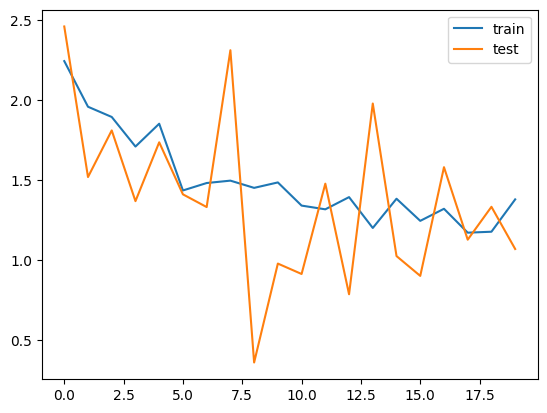

In [19]:
from matplotlib import pyplot as plt

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()
plt.show()

In [21]:
# function to generate output sequence using greedy algorithm
def greedy_decode(model, src_courses, src_gpas, major, src_mask, src_courses_positions, src_key_padding_mask, max_len=15, start_symbol=SOS_IDX):
    model.eval()

    batch_size = src_courses.size(0)
    # Get the max value from each row
    current_semester = src_courses_positions.max(dim=1).values

    # print(f'src_mask: {src_mask}')
    # print(f'src_key_padding_mask: {src_key_padding_mask}')
    # print(f'src_courses_positions: {src_courses_positions}')

    # Encode to get memory
    memory = model.encode(major, 
                          src_courses, 
                          src_gpas, 
                          src_courses_positions, 
                          src_mask, 
                          src_key_padding_mask).to(device)
    
    # Start with the SOS token
    courses_seq = torch.ones(batch_size, 1).fill_(start_symbol).type(torch.long).to(device)
    gpas_seq = torch.zeros(batch_size, 1).type(torch.float).to(device)
    courses_pos = torch.zeros(batch_size, 1).type(torch.long).to(device)
    # print(f'courses_seq: {courses_seq.squeeze()}')
    # print(f'gpas_seq: {gpas_seq.squeeze()}')
    # print(f'courses_pos: {courses_pos.squeeze()}')
    for i in range(max_len-1):
        current_len = courses_seq.size(1)
        tgt_mask = dataset.generate_tgt_mask(current_len).to(device)
        # tgt_mask = torch.zeros(2*current_len, 2*current_len).bool().to(device)
        tgt_key_padding_mask = dataset.generate_tgt_padding_masks(courses_seq, PAD_IDX).to(device)

        # print(f'courses_seq[0]: {courses_seq[0]}')
        # print(f'tgt_mask[0]: {tgt_mask[0]}')
        # print(f'tgt_key_padding_mask[0]: {tgt_key_padding_mask[0]}')
        # print(f'tgt_mask: {tgt_mask}')
        # print(f'tgt_key_padding_mask: {tgt_key_padding_mask}')

        # Decode memory and last generated token(s)
        # print(f'memory: {memory.size()}')
        # print(f'courses_seq: {courses_seq.size()}')
        # print(f'gpas_seq: {gpas_seq.size()}')
        # print(f'courses_pos: {courses_pos.size()}')
        # print(f'tgt_mask: {tgt_mask.size()}')
        # print(f'current_len: {current_len}')

        out = model.decode(memory, 
                           courses_seq, 
                           gpas_seq, 
                           courses_pos, 
                           tgt_mask, 
                           tgt_key_padding_mask)
        # print(f'out[0]: {out[0]}')
        # print(f'out[1]: {out[1]}')
        # print(f'out: {out.size()}')
        # print(f'out_slice: {out[0, i, :].squeeze()}')
        # print(f'out_slice_gpa: {out[0, i+current_len, :].squeeze()}')

        # Take the last token's output
        # prob_courses, prob_gpas = model.generator(out[:, [i, i+current_len], :], 1)
        # print(f'out: {out[0, ]}')
        prob_courses, prob_gpas = model.generator(out, current_len)
        # HACK: Don't let it predict EOS_IDX
        # prob_courses[:, EOS_IDX, :] = 0
        # print(f'prob_courses: {prob_courses.size()}')
        _, next_course = torch.max(prob_courses[:, :, -1], dim=1)
        next_course = next_course.unsqueeze(1)
        # print(f'prob_gpas: {prob_gpas.size()}')
        next_gpa = prob_gpas[:, -1, :]

        # print(f'courses_seq: {courses_seq.size()}')
        # print(f'prob_courses: {prob_courses.size()}')
        # print(f'prob_courses: {prob_courses.squeeze()}')
        # print(f'gpas_seq: {gpas_seq.size()}')
        # print(f'prob_gpas: {prob_gpas.size()}')
        # print(f'next_course: {next_course.size()}')
        # print(f'next_gpa: {next_gpa.size()}')
        # print(f'next_course: {next_course.squeeze()}')

        # print(f'prob_gpas: {prob_gpas.squeeze()}')
        # print(f'next_course: {next_course.squeeze()}')
        
        # courses_seq and gpas_seq grows in sequence length dimension
        courses_seq = torch.cat([courses_seq, next_course], dim=1)
        gpas_seq = torch.cat([gpas_seq, next_gpa], dim=1)
        # If next_course is not PAD_IDX, set the courses_pos to current_semestser. Otherwise, set it to zero.
        # is_pad_course = (courses_seq == PAD_IDX) | (courses_seq == EOS_IDX)
        # current_pos = torch.where(is_pad_course, torch.zeros_like(courses_seq), current_semester.unsqueeze(1))
        # courses_pos = torch.cat([courses_pos, current_pos], dim=1)
        courses_pos = torch.cat([courses_pos, current_semester.unsqueeze(1)], dim=1)
        # print(f'courses_seq: {courses_seq}')
        # print()
        
        # Check if all sequences in the batch have reached EOS
        # if ((next_course == PAD_IDX) | (next_course == EOS_IDX)).all():
        #     break
    return courses_seq, gpas_seq

In [22]:
# actual function to translate input sentence into target language
def predict(model, major, src_courses, src_gpas, src_courses_positions):
    # Source mask
    src_seq_len = 1 + src_courses.size(1) + src_gpas.size(1)
    src_mask = dataset.generate_src_mask(src_seq_len).to(device)
    
    # Padding masks
    src_key_padding_mask = dataset.generate_src_padding_masks(src_courses, major, PAD_IDX).to(device)

    # Place on device
    major = major.to(device)
    src_courses = src_courses.to(device)
    src_gpas = src_gpas.to(device)
    src_courses_positions = src_courses_positions.to(device)
    src_key_padding_mask = src_key_padding_mask.to(device)
    src_mask = src_mask.to(device)

    with torch.no_grad():
        pred_courses, pred_gpas = greedy_decode(model, 
                                                src_courses, 
                                                src_gpas,
                                                major,
                                                src_mask,
                                                src_courses_positions,
                                                src_key_padding_mask)
    return pred_courses, pred_gpas

In [28]:
# Predict on a batch from the test set
for src_courses, src_courses_positions, tgt_courses, tgt_courses_positions, majors, src_gpas, target_grades in test_dataloader:
    pred_courses, pred_gpas = predict(model, majors, src_courses, src_gpas, src_courses_positions)
    break

In [29]:
actual_src_courses = [id_course_map[x.item()] for x in src_courses[0]]
actual_tgt_courses = [id_course_map[x.item()] for x in tgt_courses[0]]
pred_tgt_courses = [id_course_map[x.item()] for x in pred_courses[0]]

print(f'Major: {id_major_map[majors[0].item()]}')
print(f'Actual source courses: {actual_src_courses}')
print(f'Actual target courses: {actual_tgt_courses}')
print(f'Predicted target courses: {pred_tgt_courses}')

Major: Psychology
Actual source courses: ['<SOS>', 'PSYC 2317', 'COMM 1317', 'FSTY 1310', 'PSYC 2307', 'FSTY 1311', 'ENGW 1302', 'CULF 1320', 'APSC 1110', 'PSYC 2305', 'PSYC 2316', 'PSYC 3319', '<OTHER>', 'CULF 2321', 'CULF 1318', 'PSYC 2306', 'PSYC 3438', '<OTHER>', 'SCIE 2320', 'PHIL 1301', 'PSYC 2308', 'PSYC 2321', 'PHIL 2329', 'SPAN 1311', 'CULF 3330', 'PSYC 4344', 'PSYC 3438', 'PSYC 4343', 'RELS 1304', 'SPAN 1312', 'BIOL 1310', '<OTHER>', 'SABR 2150', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Actual target courses: ['<SOS>', '<OTHER>', 'PSYC 4359', 'KINE 1119', 'PSYC 4360', 'PSYC 2349', 'KINE 1109', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Predicted target courses: ['<SOS>', 'PSYC 4341', 'PSYC 4359', 'PSYC 4442', 'PSYC 4360', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>']


In [30]:
src_courses[0], tgt_courses[0], pred_courses[0]

(tensor([358,   2,  28, 162, 207, 211,  90,  94, 163, 193, 196,   4,  17,  98,
          99, 250,   6,  17,  97, 168, 206,   3,  38,  43, 177, 204,   6,  11,
          23,  44, 195,  17, 124, 359,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]),
 tensor([358,  17,  18, 151, 209, 261, 288, 359,   0,   0,   0,   0]),
 tensor([358,   7,  18,  19, 209, 359, 359, 359, 359, 359, 359, 359, 359, 359,
         359], device='cuda:0'))

## Predictions

In [ ]:
def predictAR(device, dataloader, model, SOS_TOKEN, EOS_TOKEN, course_map):
    model.to(device)
    model.eval()  # Set the model to evaluation mode

    total_iou = 0
    total_sequences = 0

    with torch.no_grad():  # No need to track gradients during inference
        for batch, (X, X_pos, y, y_pos, X_pad_mask, y_pad_mask, majors, input_grades, target_grades) in enumerate(dataloader):
            max_len = y.size(1)
            batch_size = X.size(0)

            # Initialize EOS tracking tensor
            eos_reached = torch.zeros(batch_size, dtype=torch.bool, device=device)

            # Initialize empty tensors to hold predictions
            generated_courses = torch.zeros(batch_size, max_len, device=device, dtype=torch.long)
            generated_gpas = torch.zeros(batch_size, max_len, device=device)

            # Move data to device
            X = X.to(device)
            y = y.to(device)
            X_pos = X_pos.to(device)
            y_pos = y_pos.to(device)
            X_pad_mask = X_pad_mask.to(device)
            y_pad_mask = y_pad_mask.to(device)
            majors = majors.to(device)
            input_grades = input_grades.to(device)
            target_grades = target_grades.to(device)

            # Start with the SOS token for each sequence in the batch
            tgt_courses = torch.full((batch_size, 1), SOS_TOKEN, dtype=torch.long, device=device)
            tgt_gpas = torch.zeros(batch_size, 1, device=device)

            for t in range(1, max_len + 1):
                current_tgt_pos = y_pos[:, :t]
                current_tgt_pad_mask = y_pad_mask[:, :t]

                output_courses_lsm, output_gpas, _ = model(major=majors,
                                                            src_courses=X, 
                                                            tgt_courses=tgt_courses, 
                                                            src_gpas=input_grades, 
                                                            tgt_gpas=tgt_gpas, 
                                                            src_courses_positions=X_pos, 
                                                            tgt_courses_positions=current_tgt_pos,
                                                            src_courses_key_padding_mask=X_pad_mask,
                                                            tgt_courses_key_padding_mask=current_tgt_pad_mask)

                # Get the next course and GPA predictions
                next_courses = output_courses_lsm[:, :, -1].argmax(dim=1)
                next_gpa = output_gpas[:, -1, :].unsqueeze(1)

                # Store the predictions
                generated_courses[:, t-1] = next_courses
                generated_gpas[:, t-1] = next_gpa.squeeze()

                # Prepare the next step's inputs
                tgt_courses = torch.cat([tgt_courses, next_courses.unsqueeze(1)], dim=1)
                tgt_gpas = torch.cat([tgt_gpas, next_gpa.squeeze(1)], dim=1)

                eos_reached |= (next_courses == EOS_TOKEN)

                if eos_reached.all():
                    break

            # Calculate IoU for each sequence
            for i in range(batch_size):
                generated_set = set(generated_courses[i].cpu().numpy())
                target_set = set(y[i].cpu().numpy())
                generated_set.discard(0)  # Remove padding token from consideration
                target_set.discard(0)  # Remove padding token from consideration

                intersection = len(generated_set.intersection(target_set))
                union = len(generated_set.union(target_set))
                iou = intersection / union if union > 0 else 0.0
                total_iou += iou
                total_sequences += 1

                actual_courses = [course_map[course] for course in y[i].cpu().numpy() if course != 0]
                predicted_courses = [course_map[course] for course in generated_courses[i].cpu().numpy() if course != 0]

                print(f"Sample {i+1}:")
                print(f"Actual Courses: {actual_courses}")
                print(f"Predicted Courses: {predicted_courses}")
                print(f"IoU: {iou:.2%}")
                print("-" * 50)

    avg_iou = total_iou / total_sequences
    print(f"Average IoU for the batch: {avg_iou:.2%}")
    
    return avg_iou


In [ ]:
predictAR(device, test_dataloader, model, SOS_TOKEN, EOS_TOKEN, id_course_map)

c:\Users\pauls\Projects\NSCI-retention-modeling\venv\Lib\site-packages\torch\nn\functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Sample 1:
Actual Courses: ['<SOS>', 'ARTS 1311', 'ARTS 1316', 'SPAN 1311', 'VGAM 1303', 'WRIT 2302', '<EOS>']
Predicted Courses: ['ENGL 2301', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other']
IoU: 0.00%
--------------------------------------------------
Sample 2:
Actual Courses: ['<SOS>', 'ACCT 2301', 'BUSI 2303', 'BUSI 2305', 'BUSI 3330', 'MGMT 3334', '<EOS>']
Predicted Courses: ['ENGL 2301', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other']
IoU: 0.00%
--------------------------------------------------
Sample 3:
Actual Courses: ['<SOS>', 'COSC 3344', 'COSC 3344', 'COSC 4343', 'COSC 4343', 'Other', 'Other', 'Other', 'Other', '<EOS>']
Predicted Courses: ['ENGL 2301', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', 'Other', '

KeyboardInterrupt: 

In [ ]:
def predict_DEPRECATED(device, model, dataloader):
    # Put the model in evaluation mode
    model.eval()

    # iou_list = []

    # Make predictions but don't calculate gradients on forward pass
    with torch.no_grad():
        for batch, (X, X_pos, y, y_pos, X_pad_mask, y_pad_mask, majors, input_grades, target_grades) in enumerate(dataloader):
            # # Fake y value for testing
            # y_fake = y.clone()
            # # Take all non-padded values and shift them by 1 (basically a random course)
            # y_fake[y_fake != 0] = y_fake[y_fake != 0] + 1
            # # Replace any values in y_fake that are greater than n_courses with n_courses - 1 to keep within the valid range
            # y_fake[y_fake >= n_courses] = n_courses - 1
            # # Put back the SOS token
            # y_fake[:, 0] = y[:, 0]
            # y_fake = y_fake.to(device)
            # # Fake X value for testing
            
            # Place on device
            X = X.to(device)
            y = y.to(device)
            X_pos = X_pos.to(device)
            y_pos = y_pos.to(device)
            X_pad_mask = X_pad_mask.to(device)
            y_pad_mask = y_pad_mask.to(device)
            majors = majors.to(device)
            input_grades = input_grades.to(device)
            target_grades = target_grades.to(device)

            _, output_gpas, output_courses = model(major=majors,
                                                    src_courses=X, 
                                                    tgt_courses=y, 
                                                    # tgt_courses=y_fake,
                                                    src_gpas=input_grades, 
                                                    tgt_gpas=target_grades, 
                                                    src_courses_positions=X_pos, 
                                                    tgt_courses_positions=y_pos,
                                                    src_courses_key_padding_mask=X_pad_mask,
                                                    tgt_courses_key_padding_mask=y_pad_mask)

        
            # Get class predictions
            pred_courses = output_courses.argmax(dim=1)

            # print(f'output_courses[0].size(): {output_courses[0].size()}')
            # print(f'output_courses[0]: {output_courses[0]}')
            # print(f'pred_courses[0].size(): {pred_courses[0].size()}')
            # print(f'pred_courses[0]: {pred_courses[0]}')

            # Compute IOU for courses for the whole batch
            mean_iou = mean_iou_batch(pred_courses, y, n_courses)

            # # Convert predictions and acutal to sets
            # pred_courses_set = set(pred_courses[0].unique().tolist())
            # actual_courses_set = set(y[0].unique().tolist())

            # # Remove padding values for metrics
            # pred_courses_set = set([x for x in pred_courses_set if x != 0])
            # actual_courses_set = set([x for x in actual_courses_set if x != 0])
            
            # Intersection over union
            # iou = len(pred_courses_set.intersection(actual_courses_set)) / len(pred_courses_set.union(actual_courses_set))
            # iou_list.append(iou)

            # Get predicted grades
            gpas_mask = y_pos != 0
            # pred_gpas = output_gpas[gpas_mask]
            # actual_gpas = target_grades[gpas_mask]

            # Compute MAE
            # mae = torch.mean(torch.abs(pred_gpas - actual_gpas))
            # mae = masked_mae(output_gpas, target_grades, gpas_mask)   

            # for i in range(len(X)):
            #     # Convert predictions and acutal to sets
            #     pred_courses_set = remove_duplicates(pred_courses[i].unique().tolist())
            #     actual_courses_set = remove_duplicates(y[i].unique().tolist())
            #     fake_courses_set = remove_duplicates(y_fake[i].unique().tolist())

            #     # Remove padding values for metrics
            #     pred_courses_set = remove_duplicates([x for x in pred_courses_set if x != 0])
            #     actual_courses_set = remove_duplicates([x for x in actual_courses_set if x != 0])

            #     # Get predicted and actual grades
            #     # gpas_mask = y_pos != 0 # Ignore padded values (semesters)
            #     # pred_gpas = output_gpas * gpas_mask # Get corresponding non-padded GPA predictions
            #     # actual_gpas = target_grades * gpas_mask # Get actual non-padded GPAs

            #     # Intersection over union
            #     iou = len(set(pred_courses_set).intersection(set(actual_courses_set))) / len(set(pred_courses_set).union(set(actual_courses_set)))
            #     iou_fake = len(set(pred_courses_set).intersection(set(fake_courses_set))) / len(set(pred_courses_set).union(set(fake_courses_set)))

            #     # Get predicted grades
            #     gpas_mask = y_pos != 0
                
            #     # pred_gpas = output_gpas[gpas_mask]
            #     # actual_gpas = target_grades[gpas_mask]

            #     # Compute MAE
            #     # mae = torch.mean(torch.abs(pred_gpas - actual_gpas))
            #     # mae = masked_mae(output_gpas, target_grades, gpas_mask, row_wise=True)

            #     print(f'Major: {id_major_map[majors[i].item()]}')
            #     print(f'Semester: {y_pos[i].unique()[1].item()}')
            #     print(f'Prior semesters: {[id_course_map[x] for x in X[i].tolist() if x != 0]}')
            #     print(f'Prior semester grades: {[np.round(4.3*x, 2) for x, i in zip(input_grades[i].tolist(), X[i].tolist()) if i != 0]}')
            #     print(f'(Courses) Actual: {remove_duplicates([id_course_map[x.item()] for x in y[i] if x != 0])}')
            #     print(f'(Courses) Fake: {remove_duplicates([id_course_map[x.item()] for x in y_fake[i] if x != 0])}')
            #     print(f'(Courses) Predicted: {[id_course_map[x] for x in pred_courses_set]}')
            #     # print(f'(Grades) Actual: {[np.round(4.3*x, 2) for x in actual_gpas.tolist() if x != 0]}')
            #     # print(f'(Grades) Predicted: {[np.round(4.3*x, 2) for x in pred_gpas.tolist() if x != 0]}, MAE: {mae:.4f}')
            #     print(f'IOU with real data: {iou:.1%}')
            #     print(f'IOU with fake data: {iou_fake:.1%}')
            #     # print(f'IOU%: {iou:.1%}, MAE: {mae[i]:.4f}')
            #     print('-'*20)
            # break

In [ ]:
predict(device, model, test_dataloader)

tensor([358], device='cuda:0')


c:\Users\pauls\Projects\NSCI-retention-modeling\venv\Lib\site-packages\torch\nn\functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


output_courses.size(): torch.Size([64, 359, 19])
next_token.size(): torch.Size([64, 19])

tensor([358, 314, 314, 314, 314, 314, 314, 314,  50,  50,  50,  50,  50,  50,
         50,  50,  50,  50,  50,  50], device='cuda:0')
output_courses.size(): torch.Size([64, 359, 19])
next_token.size(): torch.Size([64, 19])

tensor([358, 314, 314, 314, 314, 314, 314, 314,  50,  50,  50,  50,  50,  50,
         50,  50,  50,  50,  50,  50, 314, 314, 314, 314, 314, 314, 314,  50,
         50,  50,  50,  50,  50,  50,  50,  50,  50,  50,  50],
       device='cuda:0')
output_courses.size(): torch.Size([64, 359, 19])
next_token.size(): torch.Size([64, 19])

tensor([358, 314, 314, 314, 314, 314, 314, 314,  50,  50,  50,  50,  50,  50,
         50,  50,  50,  50,  50,  50, 314, 314, 314, 314, 314, 314, 314,  50,
         50,  50,  50,  50,  50,  50,  50,  50,  50,  50,  50, 314, 314, 314,
        314, 314, 314, 314,  50,  50,  50,  50,  50,  50,  50,  50,  50,  50,
         50,  50], device='cuda:0')
outp

KeyboardInterrupt: 

## Custom predictions

Let the user "create" a student and then have the model predict courses and grades. This will allow us to play with different factors (e.g. course sequencing, different majors, etc) to see the results.

In [ ]:
tgt_semester = y_pos[0].max().item()

# Grab just the first row for prediction
pred_src_courses=X[0].unsqueeze(0).type(torch.long).to(device)
pred_src_gpas=input_grades[0].unsqueeze(0).to(device)
pred_src_courses_positions=X_pos[0].unsqueeze(0).type(torch.long).to(device)
pred_src_courses_key_padding_mask=X_pad_mask[0].unsqueeze(0).type(torch.bool).to(device)
pred_majors=majors[0].unsqueeze(0).type(torch.long).to(device)
pred_memory_key_padding_mask=None

# Actuals for comparison
actual_tgt_courses=tgt_courses[0].unsqueeze(0).to(device)
actual_tgt_gpas=tgt_gpas[0].unsqueeze(0).to(device)
actual_tgt_courses_positions=tgt_courses_positions[0].unsqueeze(0).to(device)
actual_tgt_courses_key_padding_mask=tgt_courses_key_padding_mask[0].unsqueeze(0).to(device)

# # Create targets for prediction
# pred_tgt_courses=torch.full((1, 1), actual_tgt_courses[0][0].item(), dtype=torch.long).to(device)
# pred_tgt_gpas=torch.full((1, 1), actual_tgt_gpas[0][0].item(),dtype=torch.float).to(device)
# pred_tgt_courses_positions=torch.full_like(pred_tgt_courses, fill_value=tgt_semester, dtype=torch.long).to(device)
# pred_tgt_courses_key_padding_mask=torch.ones_like(pred_tgt_courses, dtype=torch.bool).to(device)

In [ ]:
print(f'major: {pred_majors[0]}\n')
print(f'src_courses:\n {pred_src_courses[0]}\n')
# print(f'tgt_courses:\n {pred_tgt_courses[0]}\n')
print(f'src_gpas:\n {pred_src_gpas[0]}\n')
# print(f'tgt_gpas:\n {pred_tgt_gpas[0]}\n')
print(f'src_courses_positions:\n {pred_src_courses_positions[0]}\n')
# print(f'tgt_courses_positions:\n {pred_tgt_courses_positions[0]}\n')
print(f'src_courses_key_padding_mask:\n {pred_src_courses_key_padding_mask[0]}\n')
# print(f'tgt_courses_key_padding_mask:\n {pred_tgt_courses_key_padding_mask[0]}\n')

major: 31

src_courses:
 tensor([296, 341,  28,  96, 198,  31,  44,  17, 103,  73,  51, 256, 114,  23,
         13,  72,  17, 259,  17, 126,   8, 297,  17, 260,  38,  52,  53,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0], device='cuda:0')

src_gpas:
 tensor([0.8605, 0.9302, 0.7674, 0.9302, 0.9302, 0.9302, 1.0000, 1.0000, 0.8605,
        0.6977, 0.4651, 0.9302, 0.9302, 0.9302, 0.9302, 0.9302, 0.9302, 0.9302,
        0.9302, 0.9302, 0.0000, 0.9302, 0.9302, 0.9302, 0.9302, 0.6977, 0.7674,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')

src_courses_positions:
 tensor([1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2

Have the model make a prediction

In [ ]:
model.eval()

with torch.no_grad():
    output_courses_lsm, output_gpas, output_courses = model(major=pred_majors,
                                                            src_courses=pred_src_courses, 
                                                            # tgt_courses=pred_tgt_courses, 
                                                            tgt_courses=actual_tgt_courses,
                                                            src_gpas=pred_src_gpas, 
                                                            # tgt_gpas=pred_tgt_gpas, 
                                                            tgt_gpas=actual_tgt_gpas,
                                                            src_courses_positions=pred_src_courses_positions, 
                                                            # tgt_courses_positions=pred_tgt_courses_positions,
                                                            tgt_courses_positions=actual_tgt_courses_positions,
                                                            src_courses_key_padding_mask=pred_src_courses_key_padding_mask,
                                                            tgt_courses_key_padding_mask=actual_tgt_courses_key_padding_mask
                                                            # tgt_courses_key_padding_mask=pred_tgt_courses_key_padding_mask)
    )
    # Get class predictions
    pred_courses = output_courses.topk(k=10, dim=1).indices

In [ ]:
pred_courses.squeeze()

tensor([[314, 358, 358,  17,  36,  17, 314, 298, 298, 298, 298, 298, 298, 298,
         298, 298, 298, 298, 298],
        [237,  17,  17, 358,  51, 358, 330,  17,  17,  17,  17,  17,  17,  17,
          17,  17,  17,  17,  17],
        [148, 311, 311, 311, 314, 311,  51, 358, 358, 358, 358, 358, 358, 358,
         358, 358, 358, 358, 358],
        [320, 212, 212, 212, 300, 220, 148, 145, 145, 145, 145, 145, 145, 145,
         145, 145, 145, 145, 145],
        [ 51, 216, 267, 267, 148, 212,  76, 262, 262, 262, 262, 262, 262, 262,
         262, 262, 262, 262, 262],
        [330,  91,  91,  91, 330, 298, 320, 253, 253, 253, 253, 253, 253, 253,
         253, 253, 253, 253, 253],
        [ 14, 267, 216, 220, 307,  91, 184, 177, 177, 177, 177, 177, 177, 177,
         177, 177, 177, 177, 177],
        [278, 200, 200, 216, 137, 160, 223, 100, 100, 100, 100, 100, 100, 100,
         100, 100, 100, 100, 100],
        [ 36, 220, 220, 200, 184, 216, 237, 274, 274, 274, 274, 274, 274, 274,
         

Predicted courses

In [ ]:
pred_course_set = set([id_course_map[x] for x in pred_courses.squeeze().tolist()])
actual_course_set = set([id_course_map[x] for x in actual_tgt_courses.squeeze().tolist() if x != 0])

list(pred_course_set).sort()
list(actual_course_set).sort()

print(f'Actual: {actual_course_set}\nPredicted: {pred_course_set}')

TypeError: unhashable type: 'list'

Actual courses

In [ ]:
set([id_course_map[x] for x in actual_tgt_courses.squeeze().tolist() if x != 0])

{'BIOL 2334', 'CHEM 2123', 'CHEM 2323', 'MATH 2413', 'WRIT 2302'}

In [ ]:
major_selector = widgets.Dropdown(
    options=major_id_map,
    value=1,
    description='Major:',
    disabled=False,
)

# Create a label which shows the selected value from the dropdown
output = widgets.Label(value=f'Selected major ID: {major_selector.value}')

def update_label(change):
    output.value = f'Selected major ID: {str(change.new)}'

major_selector.observe(update_label, names='value')

# Link the value of the dropdown to the label
display(widgets.HBox([major_selector, output]))


In [ ]:
# Create empty (zero) tensors for sources to simulate the first semester
pred_empty_src_courses = torch.zeros_like(X, dtype=torch.long)[0].unsqueeze(0).to(device)
pred_empty_src_gpas = torch.zeros_like(input_grades, dtype=torch.float)[0].unsqueeze(0).to(device)
pred_empty_src_courses_positions = torch.zeros_like(X_pos, dtype=torch.long)[0].unsqueeze(0).to(device)
pred_empty_src_courses_key_padding_mask = torch.zeros_like(X_pad_mask, dtype=torch.bool)[0].unsqueeze(0).to(device)
pred_empty_majors = torch.LongTensor([major_selector.value]).to(device)

# Create empty (zero) tensors for targets to simulate the first semester
pred_empty_tgt_courses = torch.zeros((1, 1), dtype=torch.long).to(device)
pred_empty_tgt_gpas = torch.zeros((1, 1), dtype=torch.float).to(device)
pred_empty_tgt_courses_positions = torch.ones((1, 1), dtype=torch.long).to(device)
pred_empty_tgt_courses_key_padding_mask = torch.ones((1, 1), dtype=torch.bool).to(device)


Sanity check to make sure everything looks good (besides major and indicator for first semester, it should all be zeros).

In [ ]:
print(f'src_courses:\n {pred_empty_src_courses}\n')
print(f'tgt_courses:\n {pred_empty_tgt_courses}\n')
print(f'src_gpas:\n {pred_empty_src_gpas}\n')
print(f'tgt_gpas:\n {pred_empty_tgt_gpas}\n')
print(f'major: {pred_empty_majors}\n')
print(f'src_courses_positions:\n {pred_empty_src_courses_positions}\n')
print(f'tgt_courses_positions:\n {pred_empty_tgt_courses_positions}\n')
print(f'src_courses_key_padding_mask:\n {pred_empty_src_courses_key_padding_mask}\n')
print(f'tgt_courses_key_padding_mask:\n {pred_empty_tgt_courses_key_padding_mask}\n')

src_courses:
 tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0')

tgt_courses:
 tensor([[0]], device='cuda:0')

src_gpas:
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')

tgt_gpas:
 tensor([[0.]], device='cuda:0')

major: tensor([1], device='cuda:0')

src_courses_positions:
 tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0')

tgt_courses_positions:
 tensor([[1]], device='cuda:0')

src_courses_key_padding_mask:
 tensor

In [ ]:
model.eval()

output_courses_lsm, output_gpas, output_courses = model(major=pred_empty_majors,
                                                        src_courses=pred_empty_src_courses, 
                                                        tgt_courses=pred_empty_tgt_courses, 
                                                        src_gpas=pred_empty_src_gpas, 
                                                        tgt_gpas=pred_empty_tgt_gpas, 
                                                        src_courses_positions=pred_empty_src_courses_positions, 
                                                        tgt_courses_positions=pred_empty_tgt_courses_positions,
                                                        src_courses_key_padding_mask=pred_empty_src_courses_key_padding_mask,
                                                        tgt_courses_key_padding_mask=pred_empty_tgt_courses_key_padding_mask)
# Get class predictions
pred_course = output_courses.topk(k=10, dim=1).indices


In [ ]:
set([id_course_map[x] for x in pred_course.squeeze().tolist()])

{'<PAD>',
 'BIOL 2334',
 'PSYC 2310',
 'PSYC 2317',
 'PSYC 2321',
 'PSYC 3319',
 'PSYC 3352',
 'PSYC 3438',
 'PSYC 4341',
 'WRIT 2302'}

## Major embeddings
Understand if the major embeddings are capturing anything meaningful (or even being used)

In [20]:
with torch.no_grad():
    model.eval()

    # Majors
    major_idxs = np.arange(n_majors)
    major_tensor = torch.tensor(major_idxs).to(device)
    major_embeddings = model.major_embedding(major_tensor).squeeze()

    # Courses
    course_idxs = np.arange(n_courses)
    course_tensor = torch.tensor(course_idxs).to(device)
    course_embeddings = model.course_embedding(course_tensor).squeeze()



In [21]:
def find_k_closest(tensor, row_index, k):
    """
    Find the K closest rows in `tensor` to the row at `row_index` using cosine similarity.

    Args:
    - tensor (torch.Tensor): Input tensor of shape [batch size, embedding size].
    - row_index (int): Index of the row to compare against.
    - k (int): Number of closest rows to find.

    Returns:
    - indices (torch.Tensor): Indices of the K closest rows.
    """
    # Compute cosine similarities
    normalized_tensor = F.normalize(tensor, p=2, dim=1)
    cosine_similarities = torch.matmul(normalized_tensor, normalized_tensor[row_index].unsqueeze(1)).squeeze()

    # Set the similarity of the row with itself to -1 to exclude it from being one of the closest
    cosine_similarities[row_index] = -1

    # Find the indices of the K largest similarities (which are the closest)
    _, indices = torch.topk(cosine_similarities, k, largest=True)
    
    return indices

In [22]:
def find_k_farthest(tensor, row_index, k):
    """
    Find the K farthest rows in `tensor` to the row at `row_index` using cosine similarity.

    Args:
    - tensor (torch.Tensor): Input tensor of shape [batch size, embedding size].
    - row_index (int): Index of the row to compare against.
    - k (int): Number of farthest rows to find.

    Returns:
    - indices (torch.Tensor): Indices of the K farthest rows.
    """
    # Compute cosine similarities
    normalized_tensor = F.normalize(tensor, p=2, dim=1)
    cosine_similarities = torch.matmul(normalized_tensor, normalized_tensor[row_index].unsqueeze(1)).squeeze()

    # Set the similarity of the row with itself to 1 to exclude it from being one of the farthest
    cosine_similarities[row_index] = 1

    # Find the indices of the K smallest similarities (which are the farthest)
    _, indices = torch.topk(cosine_similarities, k, largest=False)
    
    return indices

In [23]:
def find_neighbors(embeddings, name, id_name_map, name_id_map, k=5):
    nbrs = find_k_closest(embeddings, name_id_map[name], k=k)

    return [id_name_map[x.item()] for x in nbrs]

In [24]:
def find_farthest_neighbors(embeddings, name, id_name_map, name_id_map, k=5):
    nbrs = find_k_farthest(embeddings, name_id_map[name], k=k)
    return [id_name_map[x.item()] for x in nbrs]

In [30]:
test_major = 'Biology'

In [31]:
find_neighbors(major_embeddings, test_major, id_major_map, major_id_map, 10)

['Computer Info Science',
 'Communication',
 'Writing and Rhetoric',
 'Chemistry',
 'Political Science',
 'Interdisciplinary Studies',
 'Behavioral Neuroscience',
 'Art',
 'Management',
 'International Business']

In [32]:
find_farthest_neighbors(major_embeddings, test_major, id_major_map, major_id_map, 10)

['Computer Science',
 'History',
 'Theater Arts',
 'Philosophy',
 'Global Studies',
 'Entrepreneurship',
 'Graphic Design',
 'Academic Exploration-ND',
 'Forensic Science',
 'Forensic Science, Laboratory']

In [28]:
test_course = 'MATH 2413'
find_neighbors(course_embeddings, test_course, id_course_map, course_id_map, 10)

['POLS 2341',
 'PSYC 2301',
 'CRIJ 2306',
 'BIOL 2113',
 'KINE 1129',
 'ACCT 2301',
 'COSC 2331',
 'VGAM 1303',
 'CRIJ 1310',
 'ASTR 1311']

In [29]:
find_farthest_neighbors(course_embeddings, test_course, id_course_map, course_id_map, 10)

['GEOG 1303',
 'MATH 309',
 'ENGL 2324',
 'FSEM 1409',
 'COSC 2425',
 'FSEM 1407',
 'RELS 1315',
 'KINE 2335',
 'COSC 2325',
 'PHYS 2425']

# Inspecting attention weights

In [58]:
# Zero the gradients first
model.zero_grad()

# Example forward pass (replace with your actual input data)
output_courses_lsm, output_gpas, output_courses = model(major=majors,
                                                        src_courses=X, 
                                                        tgt_courses=y, 
                                                        src_gpas=input_grades, 
                                                        tgt_gpas=target_grades, 
                                                        src_courses_positions=X_pos, 
                                                        tgt_courses_positions=y_pos,
                                                        src_courses_key_padding_mask=X_pad_mask,
                                                        tgt_courses_key_padding_mask=y_pad_mask)

# Compute the loss (replace with your actual loss function)
# Course prediction loss function
# Summing along dimension 1 creates a vector which has a 1 for each
# course they actually took. Padding will be counted multiple times to
# encourage the model to not over-predict courses.
y_oh = F.one_hot(y, num_classes=n_courses).sum(dim=1)
y_oh = torch.clamp(y_oh, 0, 1)
y_norm = y_oh / y_oh.sum(dim=1, keepdim=True)

# Mask the padding values when computing loss
course_loss = course_loss_fn(output_courses_lsm, y_norm)
mask = torch.ones_like(y_oh)
mask[:, 0] = 0
masked_loss = course_loss * mask
course_reduced_loss = masked_loss.sum() / mask.sum()

# GPA loss function
# Mask the padding values when computing loss
gpa_loss = gpa_loss_fn(output_gpas.squeeze(), target_grades.squeeze())
mask = torch.ones_like(target_grades)
mask[y_pos == 0] = 0
masked_loss = gpa_loss * mask
gpa_reduced_loss = masked_loss.sum() / mask.sum()

loss = course_loss_weight*course_reduced_loss + gpa_reduced_loss

# Backward pass to compute gradients
loss.backward()

# Inspect gradients of a specific parameter or layer
print("Gradients for the self-attention layer weights in the first encoder layer:")
print(model.transformer.encoder.layers[0].self_attn.in_proj_weight.grad)

grad_dict = dict()

for name, param in model.named_parameters():
    if param.grad is not None and '.bias' not in name:
        grad_dict[name] = [param.grad.abs().max().item(), param.grad.abs().min().item(), param.grad.data.norm(p=2).item()]
        # print(f"Gradients for {name}:")
        # print(f'Max: {param.grad.abs().max()}')
        # print(f'Min: {param.grad.abs().min()}\n')

import pandas as pd

# Make a dual bar plot of the max and min gradients for each parameter
grad_df = pd.DataFrame(grad_dict).T
grad_df.columns = ['Max', 'Min', 'L2 norm']
grad_df = grad_df.sort_values(by='Max', ascending=False)
grad_df_zero = grad_df[grad_df['Max'] <= 1e-8]
grad_df = grad_df[grad_df['Max'] > 1e-8]
grad_df['Max_log'] = np.log(grad_df['Max'])
grad_df['L2 norm log'] = np.log(grad_df['L2 norm'])

# Plot the dual bar chart
fig, ax = plt.subplots(figsize=(10, 40))
grad_df['L2 norm log'].plot(kind='barh', ax=ax)


Gradients for the self-attention layer weights in the first encoder layer:
None


ValueError: Length mismatch: Expected axis has 0 elements, new values have 3 elements

In [ ]:
grad_df_zero

,Max,Min
